In [1]:
import numpy as np
import pandas as pd
from scipy.stats import kstest,ttest_ind
import itertools as it
from collections import Counter
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 7, 'ytick.major.width': 1.5, 'ytick.major.size': 7})
from matplotlib.backends.backend_pdf import PdfPages
from functools import reduce

In [2]:
def save_pdf(save_file, fig):
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight')
    pdf.close()
    return

def get_combo_samples(combos, genotype_df):
    samples_per_combo = genotype_df.loc[genotype_df.gene.isin(combos)].samples.str.split(",").values
    samples = reduce(lambda a,b: set(a).intersection(set(b)), samples_per_combo)
    return samples



In [3]:
genotype_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/genotype/data/processed_burden/all_gene_burden.csv.gz"
phenotype_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/phenotype/data/bmi_processed/british/train_cohort_bmi.csv.gz"
combo_files = [
    "/data6/deepro/ukb_bmi/2_rarecomb/data/british/combo2.csv",
    # "/data6/deepro/ukb_bmi/2_rarecomb/data/british/combo3.csv"
]

In [4]:
genotype_df = pd.read_csv(genotype_file)

phenotype_df = pd.read_csv(phenotype_file, usecols=["sample_names", "bmi", "bmi_prs"])
phenotype_df["bmi_decile"] = pd.qcut(phenotype_df.bmi, q=10)

combo_dfs = [pd.read_csv(cf, usecols=["uniq_items"]) for cf in combo_files]
combo_df = pd.concat(combo_dfs).reset_index(drop=True)
combo_df["combos"] = combo_df.uniq_items.apply(lambda x: [g.replace("Input_", "", 1) for g in x.split("|")])
combo_df["combo_samples"] = combo_df.combos.apply(get_combo_samples, args=(genotype_df, ))
all_combo_samples = reduce(lambda a,b: a.union(b), combo_df.combo_samples.values)


phenotype_samples_df = phenotype_df.loc[phenotype_df.sample_names.isin(list(map(int, all_combo_samples)))]

In [5]:
phenotype_samples_df = phenotype_samples_df.groupby("bmi_decile", observed=True).agg({
    "sample_names": "count",
    "bmi_prs": "mean",
    "bmi": "mean"}
    ).reset_index()
phenotype_samples_df["decile_rank"] = range(10)

In [6]:
phenotype_df.groupby("bmi_decile", observed=True).agg({
    "sample_names": "count",
    "bmi_prs": "mean",
    "bmi": "mean"}
    ).reset_index()

,bmi_decile,sample_names,bmi_prs,bmi
0,"(12.120000000000001, 22.112]",42770,-0.414920,20.723364
1,"(22.112, 23.561]",42758,-0.296629,22.882969
2,"(23.561, 24.687]",42770,-0.204601,24.138615
3,"(24.687, 25.711]",42758,-0.135249,25.202332
4,"(25.711, 26.729]",42767,-0.061813,26.214963
5,"(26.729, 27.828]",42791,0.011006,27.265109
6,"(27.828, 29.104]",42764,0.089421,28.446594
7,"(29.104, 30.773]",42741,0.171837,29.889651
8,"(30.773, 33.493]",42761,0.302425,31.980664
9,"(33.493, 74.684]",42759,0.538724,37.348775


In [7]:
phenotype_samples_df

,bmi_decile,sample_names,bmi_prs,bmi,decile_rank
0,"(12.120000000000001, 22.112]",83,-0.324138,20.773779,0
1,"(22.112, 23.561]",122,-0.404918,22.877067,1
2,"(23.561, 24.687]",95,-0.365853,24.151871,2
3,"(24.687, 25.711]",110,-0.197673,25.187014,3
4,"(25.711, 26.729]",128,-0.079286,26.220541,4
5,"(26.729, 27.828]",134,0.061172,27.265563,5
6,"(27.828, 29.104]",124,-0.064906,28.449866,6
7,"(29.104, 30.773]",195,-0.158524,29.981821,7
8,"(30.773, 33.493]",349,0.126342,32.066629,8
9,"(33.493, 74.684]",428,0.521489,37.210249,9


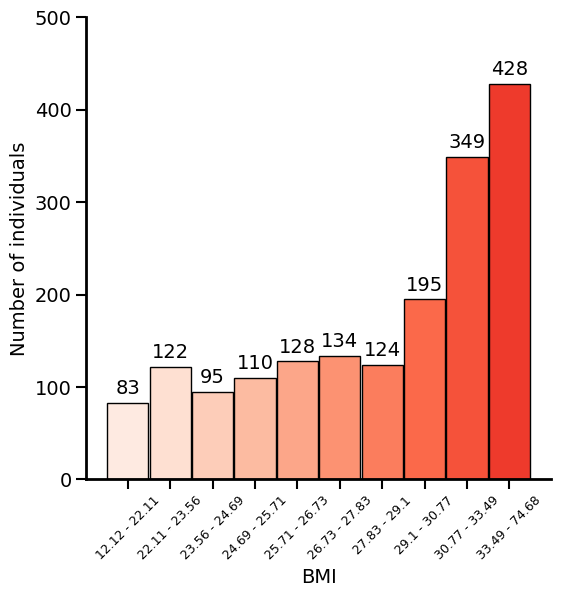

In [10]:
def create_decile_rank_plot(df, decile_labels):
    fig,ax = plt.subplots(1,1,figsize=(6, 6))
    ax.bar(df.decile_rank, df.sample_names, width=0.97, color=sns.color_palette("Reds", 15).as_hex()[:10], edgecolor="k")
    xticklabels = decile_labels
    ax.set_xticks(range(10), xticklabels, rotation=45, ha="center", fontsize=9)
    ax.set_xlabel("BMI")
    ax.set_ylabel("Number of individuals")
    # g.bar_label([g.containers[i] for i in range])
    rects = ax.patches
    # Make some labels.
    for rect in rects:
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, f"{height}", ha="center", va="bottom"
        )
    ax.set_ylim(0, 500)
    ax.spines[['right', 'top']].set_visible(False)
    return fig,ax

fig, ax = create_decile_rank_plot(phenotype_samples_df, [" - ".join([str(round(v.left, 2)),str(round(v.right, 2))]) for v in  phenotype_samples_df.bmi_decile.values])